In [23]:
from cabi.etl.extract import load_dc_boundary
import cabi.viz as viz
import cabi.etl.load as l
import cabi.etl.transform as t
import cabi.geometry as geo
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import contextily as ctx
from functools import partial
from cabi.etl import config
import cabi.etl.extract as e
import geoplot

In [3]:
test_read = pd.read_csv('../Crashes_in_DC.csv')
test_read.columns

/opt/anaconda3/envs/cabi-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['X', 'Y', 'OBJECTID', 'CRIMEID', 'CCN', 'REPORTDATE', 'ROUTEID',
       'MEASURE', 'OFFSET', 'STREETSEGID', 'ROADWAYSEGID', 'FROMDATE',
       'TODATE', 'MARID', 'ADDRESS', 'LATITUDE', 'LONGITUDE', 'XCOORD',
       'YCOORD', 'WARD', 'EVENTID', 'MAR_ADDRESS', 'MAR_SCORE',
       'MAJORINJURIES_BICYCLIST', 'MINORINJURIES_BICYCLIST',
       'UNKNOWNINJURIES_BICYCLIST', 'FATAL_BICYCLIST', 'MAJORINJURIES_DRIVER',
       'MINORINJURIES_DRIVER', 'UNKNOWNINJURIES_DRIVER', 'FATAL_DRIVER',
       'MAJORINJURIES_PEDESTRIAN', 'MINORINJURIES_PEDESTRIAN',
       'UNKNOWNINJURIES_PEDESTRIAN', 'FATAL_PEDESTRIAN', 'TOTAL_VEHICLES',
       'TOTAL_BICYCLES', 'TOTAL_PEDESTRIANS', 'PEDESTRIANSIMPAIRED',
       'BICYCLISTSIMPAIRED', 'DRIVERSIMPAIRED', 'TOTAL_TAXIS',
       'TOTAL_GOVERNMENT', 'SPEEDING_INVOLVED', 'NEARESTINTROUTEID',
       'NEARESTINTSTREETNAME', 'OFFINTERSECTION', 'INTAPPROACHDIRECTION',
       'LOCATIONERROR', 'LASTUPDATEDATE', 'MPDLATITUDE', 'MPDLONGITUDE',
       'MPDGEOX', 'MPD

In [10]:
test_read.isna().sum()

X                                  0
Y                                  0
OBJECTID                           0
CRIMEID                            0
CCN                                0
REPORTDATE                         0
ROUTEID                            0
MEASURE                            0
OFFSET                             0
STREETSEGID                    27338
ROADWAYSEGID                   27338
FROMDATE                           0
TODATE                             0
MARID                              0
ADDRESS                           80
LATITUDE                          10
LONGITUDE                         10
XCOORD                             0
YCOORD                             0
WARD                               2
EVENTID                            0
MAR_ADDRESS                    10861
MAR_SCORE                          0
MAJORINJURIES_BICYCLIST            0
MINORINJURIES_BICYCLIST            0
UNKNOWNINJURIES_BICYCLIST          0
FATAL_BICYCLIST                    0
M

In [68]:
test_func_rows = test_read.loc[test_read[['LASTUPDATEDATE', 'REPORTDATE']].max(axis=1) == '1970/01/01 00:00:00+00', ['FROMDATE', 'TODATE', 'LASTUPDATEDATE', 'REPORTDATE']].sort_values('FROMDATE', ascending=False)

In [73]:
def val_date(date):
    return date > '1970/01/01 00:00:01'

def max_date(row):
    dates = row[['FROMDATE', 'TODATE', 'LASTUPDATEDATE', 'REPORTDATE']]
    dates = pd.Series([date for date in dates if val_date(date)])
    if dates.any():
        result = min(dates)
    else:
        result = '1970/01/02 00:00:00+00'
    
    return result

val_date('1970/02/01 00:00:00+00')

test_func_rows.apply(lambda row: max_date(row), axis=1)

<ipython-input-73-ff3f2a1f8391>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dates = pd.Series([date for date in dates if val_date(date)])


1923      2011/08/23 04:00:00+00
222753    2011/07/03 04:00:00+00
218346    2011/06/28 04:00:00+00
33702     2011/06/22 04:00:00+00
13230     2011/06/07 04:00:00+00
                   ...          
79754     2000/07/08 04:00:00+00
13891     2000/06/28 04:00:00+00
132751    2000/05/15 04:00:00+00
79867     2000/04/16 04:00:00+00
157513    1970/01/02 00:00:00+00
Length: 1081, dtype: object

In [75]:
date_cols = ['FROMDATE', 'TODATE', 'LASTUPDATEDATE', 'REPORTDATE']

In [74]:
df = test_read.drop(
    ['X', 'Y', 'OBJECTID', 'CCN', 'ROUTEID', 'MEASURE', 'STREETSEGID',
     'ROADWAYSEGID', 'MPDLATITUDE', 'MPDLONGITUDE', 'MARID', 'ADDRESS',
     'XCOORD', 'YCOORD', 'EVENTID', 'MAR_ADDRESS', 'MAR_SCORE', 'MAJORINJURIES_DRIVER',
     'MINORINJURIES_DRIVER', 'UNKNOWNINJURIES_DRIVER', 'FATAL_DRIVER',
     'TOTAL_GOVERNMENT', 'SPEEDING_INVOLVED', 'NEARESTINTROUTEID',
     'PEDESTRIANSIMPAIRED', 'BICYCLISTSIMPAIRED', 'DRIVERSIMPAIRED',
     'MPDGEOX', 'MPDGEOY', 'BLOCKKEY', 'SUBBLOCKKEY', 'FATALPASSENGER',
     'MAJORINJURIESPASSENGER', 'MINORINJURIESPASSENGER',
     'UNKNOWNINJURIESPASSENGER', 'LOCATIONERROR'], axis=1)

df

,CRIMEID,REPORTDATE,OFFSET,FROMDATE,TODATE,LATITUDE,LONGITUDE,WARD,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,...,UNKNOWNINJURIES_PEDESTRIAN,FATAL_PEDESTRIAN,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS,TOTAL_TAXIS,NEARESTINTSTREETNAME,OFFINTERSECTION,INTAPPROACHDIRECTION,LASTUPDATEDATE
0,25254865,2015/04/09 05:00:00+00,20.72,2015/04/09 04:00:00+00,1970/01/01 00:00:00+00,38.867272,-76.986818,Ward 8,0,0,...,0,0,2,0,0,0,13TH ST SE,16.42,East,1970/01/01 00:00:00+00
1,25254866,2015/04/10 05:00:00+00,24.52,2015/04/10 04:00:00+00,1970/01/01 00:00:00+00,38.911631,-77.043718,Ward 2,0,0,...,0,0,1,0,0,0,CORCORAN ST NW,26.34,South,1970/01/01 00:00:00+00
2,24206292,2012/09/11 05:00:00+00,0.01,2012/09/11 04:00:00+00,1970/01/01 00:00:00+00,38.911170,-76.932750,Ward 7,0,0,...,0,0,2,0,0,0,47TH AVE NE,0.02,Northwest,1970/01/01 00:00:00+00
3,24758524,2013/09/22 05:00:00+00,33.30,2013/09/22 04:00:00+00,1970/01/01 00:00:00+00,38.896019,-77.040346,Ward 2,0,0,...,0,0,3,0,0,0,STATE PL NW,34.32,West,1970/01/01 00:00:00+00
4,26827738,2016/01/21 21:13:35+00,9.05,2016/01/20 05:00:00+00,1970/01/01 00:00:00+00,38.831276,-77.010477,Ward 8,0,0,...,0,0,2,0,0,0,1ST PL SW,44.83,Northeast,1970/01/01 00:00:00+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235644,24222365,2012/09/21 05:00:00+00,29.99,2012/09/21 04:00:00+00,1970/01/01 00:00:00+00,38.916988,-77.003163,Ward 5,0,0,...,0,0,2,0,0,0,U ST NE,1.22,South,1970/01/01 00:00:00+00
235645,26974878,2016/06/16 22:42:12+00,1.54,2016/06/16 04:00:00+00,1970/01/01 00:00:00+00,38.927528,-77.064027,Ward 3,0,0,...,0,0,4,0,0,0,32ND ST NW,35.07,West,1970/01/01 00:00:00+00
235646,27368095,2017/07/13 04:51:32+00,5.53,2017/07/12 04:00:00+00,1970/01/01 00:00:00+00,38.872032,-77.009436,Ward 6,0,0,...,0,0,2,0,0,0,Alley-47000462,9.93,East,1970/01/01 00:00:00+00
235647,27944060,2019/02/07 01:21:04+00,1.10,2019/02/06 05:00:00+00,1970/01/01 00:00:00+00,38.902851,-77.027027,Ward 2,0,0,...,0,0,2,0,0,0,Alley-47015462,18.99,South,1970/01/01 00:00:00+00


In [18]:
df.TOTAL_TAXIS.value_counts()

0    217615
1     17177
2       843
3        12
4         2
Name: TOTAL_TAXIS, dtype: int64

In [76]:
bike_ped_cols = [col for col in df if ('BICYCLIST' in col) | ('PEDESTRIAN' in col)]
bike_ped_cols

['MAJORINJURIES_BICYCLIST',
 'MINORINJURIES_BICYCLIST',
 'UNKNOWNINJURIES_BICYCLIST',
 'FATAL_BICYCLIST',
 'MAJORINJURIES_PEDESTRIAN',
 'MINORINJURIES_PEDESTRIAN',
 'UNKNOWNINJURIES_PEDESTRIAN',
 'FATAL_PEDESTRIAN',
 'TOTAL_PEDESTRIANS']

In [82]:
df

,CRIMEID,REPORTDATE,OFFSET,FROMDATE,TODATE,LATITUDE,LONGITUDE,WARD,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,...,UNKNOWNINJURIES_PEDESTRIAN,FATAL_PEDESTRIAN,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS,TOTAL_TAXIS,NEARESTINTSTREETNAME,OFFINTERSECTION,INTAPPROACHDIRECTION,LASTUPDATEDATE
0,25254865,2015/04/09 05:00:00+00,20.72,2015/04/09 04:00:00+00,1970/01/01 00:00:00+00,38.867272,-76.986818,Ward 8,0,0,...,0,0,2,0,0,0,13TH ST SE,16.42,East,1970/01/01 00:00:00+00
1,25254866,2015/04/10 05:00:00+00,24.52,2015/04/10 04:00:00+00,1970/01/01 00:00:00+00,38.911631,-77.043718,Ward 2,0,0,...,0,0,1,0,0,0,CORCORAN ST NW,26.34,South,1970/01/01 00:00:00+00
2,24206292,2012/09/11 05:00:00+00,0.01,2012/09/11 04:00:00+00,1970/01/01 00:00:00+00,38.911170,-76.932750,Ward 7,0,0,...,0,0,2,0,0,0,47TH AVE NE,0.02,Northwest,1970/01/01 00:00:00+00
3,24758524,2013/09/22 05:00:00+00,33.30,2013/09/22 04:00:00+00,1970/01/01 00:00:00+00,38.896019,-77.040346,Ward 2,0,0,...,0,0,3,0,0,0,STATE PL NW,34.32,West,1970/01/01 00:00:00+00
4,26827738,2016/01/21 21:13:35+00,9.05,2016/01/20 05:00:00+00,1970/01/01 00:00:00+00,38.831276,-77.010477,Ward 8,0,0,...,0,0,2,0,0,0,1ST PL SW,44.83,Northeast,1970/01/01 00:00:00+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235644,24222365,2012/09/21 05:00:00+00,29.99,2012/09/21 04:00:00+00,1970/01/01 00:00:00+00,38.916988,-77.003163,Ward 5,0,0,...,0,0,2,0,0,0,U ST NE,1.22,South,1970/01/01 00:00:00+00
235645,26974878,2016/06/16 22:42:12+00,1.54,2016/06/16 04:00:00+00,1970/01/01 00:00:00+00,38.927528,-77.064027,Ward 3,0,0,...,0,0,4,0,0,0,32ND ST NW,35.07,West,1970/01/01 00:00:00+00
235646,27368095,2017/07/13 04:51:32+00,5.53,2017/07/12 04:00:00+00,1970/01/01 00:00:00+00,38.872032,-77.009436,Ward 6,0,0,...,0,0,2,0,0,0,Alley-47000462,9.93,East,1970/01/01 00:00:00+00
235647,27944060,2019/02/07 01:21:04+00,1.10,2019/02/06 05:00:00+00,1970/01/01 00:00:00+00,38.902851,-77.027027,Ward 2,0,0,...,0,0,2,0,0,0,Alley-47015462,18.99,South,1970/01/01 00:00:00+00


In [81]:
df['time'] = df.apply(lambda row: max_date(row), axis=1)
df['time']

KeyboardInterrupt: 

<AxesSubplot:>

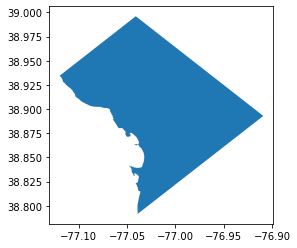

In [78]:
gdf_dc = gpd.GeoDataFrame.from_features(e.load_dc_boundary()["features"])
gdf_dc.plot()




In [32]:
gdf_dc = gdf_dc.set_crs(epsg=4326)

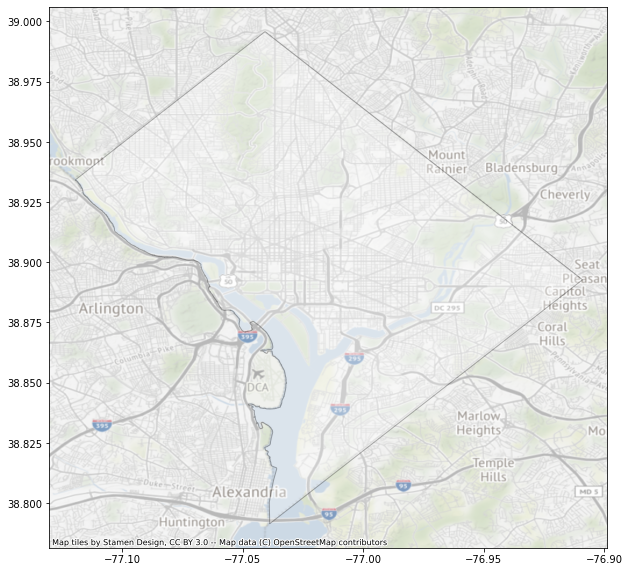

In [33]:
def dc_basemap():
    fig, ax = plt.subplots(figsize=(10,12))
    gdf_dc.plot(figsize=(10, 10), alpha=0.3, color='white', edgecolor='k', ax=ax)
    ctx.add_basemap(ax, alpha=0.5, crs=gdf_dc.crs.to_string())
    return fig, ax

_, _ = dc_basemap()

In [35]:
df.index

RangeIndex(start=0, stop=235649, step=1)

In [37]:
coords = geo.point_series(df['LONGITUDE'], df['LATITUDE'], 'coord', df.index)

In [ ]:
# fig, ax = plt.subplots(figsize=(10,12))
# ctx_gdf.plot(figsize=(10, 10), alpha=0.3, color='white', edgecolor='k', ax=ax)
# # geoplot.kdeplot(am79_ends, cmap='PuRd', shade=True, ax=ax, alpha=0.7)
# geoplot.kdeplot(pm46_ends_wday, cmap='plasma', shade=True, ax=ax, alpha=0.6)
# ax.set_aspect('equal')
# # ax.margins(-0.4, -0.4)
# # ax.set_xlim(ax.get_xlim()[0] + 0.25, ax.get_xlim()[1])
# # ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]-0.2)
# ctx.add_basemap(ax, alpha=0.5, crs=ctx_gdf.crs.to_string())
# ax.set_title('Heat Map of Trip Ending Locations Between 7-9 AM', fontsize=18)
# ax.set(xticks=[], yticks=[])
# fig.tight_layout()
# plt.show();

In [84]:
bikeped_df = df[bike_ped_cols + date_cols].join(coords)

bikeped_df['time'] = bikeped_df.apply(lambda row: max_date(row), axis=1)
bikeped_df

<ipython-input-73-ff3f2a1f8391>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dates = pd.Series([date for date in dates if val_date(date)])


,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,UNKNOWNINJURIES_BICYCLIST,FATAL_BICYCLIST,MAJORINJURIES_PEDESTRIAN,MINORINJURIES_PEDESTRIAN,UNKNOWNINJURIES_PEDESTRIAN,FATAL_PEDESTRIAN,TOTAL_PEDESTRIANS,FROMDATE,TODATE,LASTUPDATEDATE,REPORTDATE,coord,time
0,0,0,0,0,0,0,0,0,0,2015/04/09 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2015/04/09 05:00:00+00,POINT (-76.98682 38.86727),2015/04/09 04:00:00+00
1,0,0,0,0,0,0,0,0,0,2015/04/10 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2015/04/10 05:00:00+00,POINT (-77.04372 38.91163),2015/04/10 04:00:00+00
2,0,0,0,0,0,0,0,0,0,2012/09/11 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2012/09/11 05:00:00+00,POINT (-76.93275 38.91117),2012/09/11 04:00:00+00
3,0,0,0,0,0,0,0,0,0,2013/09/22 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2013/09/22 05:00:00+00,POINT (-77.04035 38.89602),2013/09/22 04:00:00+00
4,0,0,0,0,0,0,0,0,0,2016/01/20 05:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2016/01/21 21:13:35+00,POINT (-77.01048 38.83128),2016/01/20 05:00:00+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235644,0,0,0,0,0,0,0,0,0,2012/09/21 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2012/09/21 05:00:00+00,POINT (-77.00316 38.91699),2012/09/21 04:00:00+00
235645,0,0,0,0,0,0,0,0,0,2016/06/16 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2016/06/16 22:42:12+00,POINT (-77.06403 38.92753),2016/06/16 04:00:00+00
235646,0,0,0,0,0,0,0,0,0,2017/07/12 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2017/07/13 04:51:32+00,POINT (-77.00944 38.87203),2017/07/12 04:00:00+00
235647,0,0,0,0,0,0,0,0,0,2019/02/06 05:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2019/02/07 01:21:04+00,POINT (-77.02703 38.90285),2019/02/06 05:00:00+00


In [98]:
# find all rows where the incident count is > 0
bikeped_df = bikeped_df[bikeped_df[bike_ped_cols].sum(axis=1) > 0]

,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,UNKNOWNINJURIES_BICYCLIST,FATAL_BICYCLIST,MAJORINJURIES_PEDESTRIAN,MINORINJURIES_PEDESTRIAN,UNKNOWNINJURIES_PEDESTRIAN,FATAL_PEDESTRIAN,TOTAL_PEDESTRIANS,FROMDATE,TODATE,LASTUPDATEDATE,REPORTDATE,coord,time
21,0,0,0,0,0,1,0,0,1,2014/03/13 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2014/03/13 05:00:00+00,POINT (-77.00211 38.96495),2014-03-13 04:00:00+00:00
35,0,0,0,0,1,0,0,0,1,2013/09/11 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2013/09/11 05:00:00+00,POINT (-76.97930 38.89941),2013-09-11 04:00:00+00:00
45,0,0,0,0,1,0,0,0,1,2013/09/04 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2013/09/12 05:00:00+00,POINT (-77.03648 38.92869),2013-09-04 04:00:00+00:00
69,0,0,0,0,1,0,0,0,1,2012/09/11 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2012/09/11 05:00:00+00,POINT (-76.94689 38.90076),2012-09-11 04:00:00+00:00
170,0,0,0,0,0,1,0,0,1,2013/09/12 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2013/09/12 05:00:00+00,POINT (-77.03221 38.92817),2013-09-12 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235594,0,0,0,0,0,1,0,0,1,2018/08/29 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2018/08/29 23:19:54+00,POINT (-77.08353 38.95647),2018-08-29 04:00:00+00:00
235602,0,1,0,0,0,0,0,0,0,2016/10/25 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2016/10/25 22:44:50+00,POINT (-77.06115 38.90516),2016-10-25 04:00:00+00:00
235611,1,0,0,0,0,0,0,0,0,2012/07/11 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2012/07/11 15:00:00+00,POINT (-77.02808 38.89613),2012-07-11 04:00:00+00:00
235621,0,0,0,0,0,0,1,0,1,2019/05/24 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2019/05/25 04:49:25+00,POINT (-76.96568 38.85152),2019-05-24 04:00:00+00:00


In [97]:
bikeped_df['time'] = pd.to_datetime(bikeped_df.time)

bikeped_df

,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,UNKNOWNINJURIES_BICYCLIST,FATAL_BICYCLIST,MAJORINJURIES_PEDESTRIAN,MINORINJURIES_PEDESTRIAN,UNKNOWNINJURIES_PEDESTRIAN,FATAL_PEDESTRIAN,TOTAL_PEDESTRIANS,FROMDATE,TODATE,LASTUPDATEDATE,REPORTDATE,coord,time
0,0,0,0,0,0,0,0,0,0,2015/04/09 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2015/04/09 05:00:00+00,POINT (-76.98682 38.86727),2015-04-09 04:00:00+00:00
1,0,0,0,0,0,0,0,0,0,2015/04/10 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2015/04/10 05:00:00+00,POINT (-77.04372 38.91163),2015-04-10 04:00:00+00:00
2,0,0,0,0,0,0,0,0,0,2012/09/11 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2012/09/11 05:00:00+00,POINT (-76.93275 38.91117),2012-09-11 04:00:00+00:00
3,0,0,0,0,0,0,0,0,0,2013/09/22 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2013/09/22 05:00:00+00,POINT (-77.04035 38.89602),2013-09-22 04:00:00+00:00
4,0,0,0,0,0,0,0,0,0,2016/01/20 05:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2016/01/21 21:13:35+00,POINT (-77.01048 38.83128),2016-01-20 05:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235644,0,0,0,0,0,0,0,0,0,2012/09/21 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2012/09/21 05:00:00+00,POINT (-77.00316 38.91699),2012-09-21 04:00:00+00:00
235645,0,0,0,0,0,0,0,0,0,2016/06/16 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2016/06/16 22:42:12+00,POINT (-77.06403 38.92753),2016-06-16 04:00:00+00:00
235646,0,0,0,0,0,0,0,0,0,2017/07/12 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2017/07/13 04:51:32+00,POINT (-77.00944 38.87203),2017-07-12 04:00:00+00:00
235647,0,0,0,0,0,0,0,0,0,2019/02/06 05:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2019/02/07 01:21:04+00,POINT (-77.02703 38.90285),2019-02-06 05:00:00+00:00


In [100]:
bikeped_df = bikeped_df[bikeped_df[bike_ped_cols].sum(axis=1) > 0]
bikeped_df = bikeped_df.set_index('time')
bikeped_df

,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,UNKNOWNINJURIES_BICYCLIST,FATAL_BICYCLIST,MAJORINJURIES_PEDESTRIAN,MINORINJURIES_PEDESTRIAN,UNKNOWNINJURIES_PEDESTRIAN,FATAL_PEDESTRIAN,TOTAL_PEDESTRIANS,FROMDATE,TODATE,LASTUPDATEDATE,REPORTDATE,coord
time,,,,,,,,,,,,,,
2014-03-13 04:00:00+00:00,0,0,0,0,0,1,0,0,1,2014/03/13 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2014/03/13 05:00:00+00,POINT (-77.00211 38.96495)
2013-09-11 04:00:00+00:00,0,0,0,0,1,0,0,0,1,2013/09/11 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2013/09/11 05:00:00+00,POINT (-76.97930 38.89941)
2013-09-04 04:00:00+00:00,0,0,0,0,1,0,0,0,1,2013/09/04 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2013/09/12 05:00:00+00,POINT (-77.03648 38.92869)
2012-09-11 04:00:00+00:00,0,0,0,0,1,0,0,0,1,2012/09/11 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2012/09/11 05:00:00+00,POINT (-76.94689 38.90076)
2013-09-12 04:00:00+00:00,0,0,0,0,0,1,0,0,1,2013/09/12 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2013/09/12 05:00:00+00,POINT (-77.03221 38.92817)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-29 04:00:00+00:00,0,0,0,0,0,1,0,0,1,2018/08/29 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2018/08/29 23:19:54+00,POINT (-77.08353 38.95647)
2016-10-25 04:00:00+00:00,0,1,0,0,0,0,0,0,0,2016/10/25 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2016/10/25 22:44:50+00,POINT (-77.06115 38.90516)
2012-07-11 04:00:00+00:00,1,0,0,0,0,0,0,0,0,2012/07/11 04:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2012/07/11 15:00:00+00,POINT (-77.02808 38.89613)


In [103]:
bikeped_df = bikeped_df.sort_index()
bikeped_df = bikeped_df.drop(date_cols, axis=1)
bikeped_df

,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,UNKNOWNINJURIES_BICYCLIST,FATAL_BICYCLIST,MAJORINJURIES_PEDESTRIAN,MINORINJURIES_PEDESTRIAN,UNKNOWNINJURIES_PEDESTRIAN,FATAL_PEDESTRIAN,TOTAL_PEDESTRIANS,coord
time,,,,,,,,,,
1994-04-16 04:00:00+00:00,0,0,0,0,1,0,0,0,1,POINT (-77.01654 38.89431)
1996-02-18 05:00:00+00:00,0,0,0,0,0,1,0,0,1,POINT (-76.97899 38.90530)
1997-02-26 05:00:00+00:00,0,0,0,0,0,1,0,0,1,POINT (-77.05647 38.93592)
2000-01-06 05:00:00+00:00,0,0,0,0,0,1,0,0,1,POINT (-77.03752 38.90374)
2000-04-28 04:00:00+00:00,0,0,0,0,0,1,0,0,1,POINT (-77.03649 38.92684)
...,...,...,...,...,...,...,...,...,...,...
2020-08-23 04:00:00+00:00,0,1,0,0,0,0,0,0,0,POINT (-77.02758 38.93572)
2020-08-24 04:00:00+00:00,0,1,0,0,0,0,0,0,0,POINT (-77.01065 38.87929)
2020-08-24 04:00:00+00:00,0,0,0,0,0,1,0,0,1,POINT (-76.97428 38.86561)


In [108]:
y = bikeped_df[bike_ped_cols].sum(axis=1)
x = bikeped_df.index
# bikeped_df[bike_ped_cols].resample('D').sum()

<AxesSubplot:xlabel='time'>

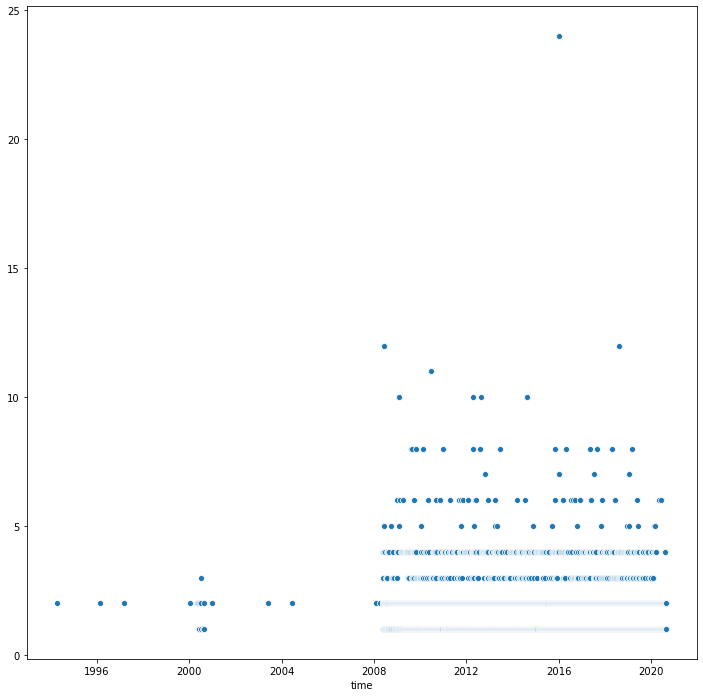

In [109]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x, y)